# Master-Part

Master-part relationships express the idea that a given entity (*master*) may include several tightly-coupled component entities (*parts*) spread across multiple tables. 
This notion is also described as *compositional integrity*.

In DataJoint's relational workflow philosophy, a master-part relationship expresses the notion of populating multiple related data artifacts in a single workflow step.

For example, a purchase order may include several items that should be treated as indivisible components of the purchase order.
Another example is a measurement from several channels: all must be recorded jointly before any downstream processing can begin.

When inserting or deleting a master entity with all its parts, the database client must do so as a single all-or-nothing (*atomic*) transaction so that the master entity always appears with all its parts.
Creating the master with any of its parts missing would constitute a violation of compositional integrity.

## Defining a Master-Part Relationship

Consider the example of a schema describing polygons which are defined by the coordinaates of its vertices. 
Here `Polygon`/`Vertex` is a master-part relationship.

In [2]:
%xmode minimal

import datajoint as dj

schema = dj.Schema('polygons')

@schema 
class Polygon(dj.Manual):
    definition = """
    polygon_id : int
    """

    class Vertex(dj.Part):
        definition = """
        -> master
        vertex_id : int 
        ---
        x : float
        y : float
        """

    # Explicit numeric datatypes such as float32 and uint16 are introduced in DataJoint 2.0.
    # Earlier versions of datajoint-python use native mysql datatypes such as INT and SMALLINT

Exception reporting mode: Minimal


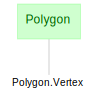

In [3]:
dj.Diagram(schema)

As seen in this example, DataJoint provides special syntax for defining master-part relationships:

1. **Master tables are declared normally** – The master entity is declared as any regular table by subclassing `dj.Manual`/`dj.Lookup`/`dj.Imported`/`dj.Computed`. Thus a table becomes a master table by virtue of having part tables.

2. **Nested class definition** – Parts are declared as a nested class inside its master class, subclassing `dj.Part`. Thus the part tables are referred to by their full class name such as `Polygon.Vertex`. Their classes do not need to be wrapped with the `@schema` decorator: the decorator of the master class is responsible for declaring all of its parts. 

3. **Foreign key from part to master** – The part tables declare a foreign key to its master directly or transitively through other parts. Inside the namespace of the master class, a special object named `master` can be used to reference the master table. Thus the definition of the `Vertex` table can declare the foreign key `-> master` as an equivalent alias to `-> Polygon`—either will form a valid foreign key. 

4. **Part tables can introduce new schema dimensions** – Unlike auto-populated master tables which cannot introduce new dimensions (see [Primary Keys](018-primary-key.md)), part tables *can* define new primary key attributes. In the example above, `Vertex` introduces the `vertex_id` dimension to identify individual vertices within each polygon. This is the mechanism by which computations can produce multiple output entities from a single input.

5. **Diagram notation** – In schema diagrams, part tables are rendered without colored blocks. They appear as labels attached to the master node, emphasizing that they do not stand on their own. Part table names that introduce new dimensions are underlined, following the standard convention for dimension-defining tables.

6. **Workflow semantics** – For computed and imported tables, the master's `make()` method is responsible for inserting both the master row and all its parts within a single ACID transaction. This ensures compositional integrity is maintained automatically.

## Master-Part Semantics

The Master-Part relationship indicates to all client applications that inserts into the master and its parts must be done inside a dedicated transaction.

**Structural rules:**

- Transactions cannot be nested and neither can master-part relationships. A part table cannot be a master table in another relationship.
- Parts can only have one master. However, a master table can have multiple part tables.
- All parts must declare a foreign key to the master, although they can do so transitively through other parts.

**Dependency semantics:**

A foreign key made by a downstream table to the master signifies a dependency on the entire collection of all its parts. 
This is a crucial property: when a table depends on a master, it implicitly depends on all the master's parts as well.
The downstream table can safely assume that whenever the master entry exists, all its associated parts are present and complete.

**Deletion behavior:**

- Deleting a master entry naturally cascades to all its parts due to the foreign key constraint.
- Parts cannot be deleted without deleting their master. Direct deletes of the parts are prohibited.

**For manual and lookup tables:**

At insert time, DataJoint does not enforce the master-part semantics for manual and lookup tables. 
The master-part notation only signals to the client applications that they must use transactions when inserting records into masters and their parts.

## Master-Part in Computed Tables

Master-part relationships are most powerful in auto-computed tables (`dj.Computed` or `dj.Imported`). 
The master is responsible for populating all its parts within a single `make` call.

### Schema Dimensions in Computed Tables

Auto-populated tables have a fundamental constraint: **they cannot introduce new schema dimensions directly**. Their primary key must be fully determined by foreign keys to their upstream dependencies. This ensures that the key source (the set of entities to be computed) is well-defined.

However, computations often produce multiple output entities from a single input—detecting multiple cells in an image, extracting multiple spikes from a recording, or identifying multiple vertices in a polygon. **Part tables solve this by being allowed to introduce new dimensions**.

In the blob detection example below, `Detection` (the master) inherits its primary key entirely from `Image` and `BlobParamSet`. It cannot add new dimensions. But `Detection.Blob` (the part) introduces the `blob_id` dimension to identify individual blobs within each detection.

### ACID Transactions

When `populate` is called, DataJoint executes each `make()` method inside an **ACID transaction**:

- **Atomicity** – The entire `make` call is all-or-nothing. Either the master row and all its parts are inserted together, or none of them are. If any error occurs—whether in computing results, inserting the master, or inserting any part—the entire transaction is rolled back. No partial results are ever committed to the database.

- **Consistency** – The transaction moves the database from one valid state to another. The master-part relationship ensures that every master entry has its complete set of parts. Referential integrity constraints are satisfied at commit time.

- **Isolation** – The transaction operates on a consistent snapshot of the database. Other concurrent transactions cannot see the partially inserted data until the transaction commits. This means other processes querying the database will never observe a master without its parts.

- **Durability** – Once the transaction commits successfully, the data is permanently stored. Even if the system crashes immediately after, the master and all its parts will be present when the database restarts.

### The Master's Responsibility

The master's `make` method is responsible for:
1. Fetching all necessary input data
2. Performing all computations
3. Inserting the master row
4. Inserting all part rows

This design ensures that the entire computation for one entity is self-contained within a single transactional boundary.

### Example: Blob Detection

Consider the [Blob Detection](../80-examples/075-blob-detection.ipynb) pipeline where `Detection` (master) and `Detection.Blob` (part) work together:

```python
@schema
class Detection(dj.Computed):
    definition = """
    -> Image
    -> BlobParamSet
    ---
    nblobs : int
    """

    class Blob(dj.Part):
        definition = """
        -> master
        blob_id : int    # NEW DIMENSION: identifies blobs within detection
        ---
        x : float
        y : float
        r : float
        """

    def make(self, key):
        # fetch inputs
        img = (Image & key).fetch1("image")
        params = (BlobParamSet & key).fetch1()

        # compute results
        blobs = blob_doh(
            img, 
            min_sigma=params['min_sigma'], 
            max_sigma=params['max_sigma'], 
            threshold=params['threshold'])

        # insert master and parts (within one transaction)
        self.insert1(dict(key, nblobs=len(blobs)))
        self.Blob.insert(
            (dict(key, blob_id=i, x=x, y=y, r=r)
             for i, (x, y, r) in enumerate(blobs)))
```

In this example:
- The `make` method is called once per `(image_id, blob_paramset)` combination
- Each call runs inside its own ACID transaction
- `Detection` cannot introduce new dimensions—its primary key is fully inherited
- `Detection.Blob` introduces the `blob_id` dimension to identify each detected blob
- The master row stores the aggregate blob count; the part rows store individual coordinates
- If `blob_doh` raises an exception or any insert fails, nothing is committed
- An image with 200 detected blobs results in 1 master row + 200 part rows, all inserted atomically

This transactional guarantee means that any downstream table depending on `Detection` can trust that all `Detection.Blob` rows for that detection are present.

## Dependency on Master Implies Dependency on Parts

A key property of master-part relationships is that **a dependency on the master is also a dependency on all its parts**.

When a downstream table declares a foreign key to a master table, it can safely assume that all the master's parts are present and complete. 
This is guaranteed by the transactional semantics: the master and its parts are always inserted together atomically.

### Example: SelectDetection

In the [Blob Detection](../80-examples/075-blob-detection.ipynb) example, `SelectDetection` allows users to mark the optimal parameter set for each image:

```python
@schema
class SelectDetection(dj.Manual):
    definition = """
    -> Image
    ---
    -> Detection
    """
```

The foreign key `-> Detection` establishes a dependency on the `Detection` master table.
Although `SelectDetection` does not explicitly reference `Detection.Blob`, it **implicitly depends on all blobs** for the referenced detection.

This has important implications:

1. **Data availability** – When querying `SelectDetection`, you can join with `Detection.Blob` knowing that all blob coordinates for the selected detection exist:
   ```python
   # Get all blobs for selected detections
   Detection.Blob & SelectDetection
   ```

2. **Cascading deletes** – If a `Detection` entry is deleted, its `Detection.Blob` parts are automatically deleted (due to the part's foreign key to master). The `SelectDetection` entry referencing that detection is also deleted (due to `SelectDetection`'s foreign key to `Detection`). The entire dependency chain is maintained.

3. **Workflow integrity** – Downstream computed tables can depend on the master and freely access both master attributes and part details. The workflow guarantees that if the master exists, all its computational results (stored in parts) are complete.

### Why This Matters

This design pattern enables clean separation of concerns:

- The **master row** stores aggregate or summary information (e.g., total blob count)
- The **part rows** store detailed, per-item information (e.g., coordinates of each blob)
- **Downstream tables** reference only the master, keeping their definitions simple
- **Queries** can access part details through joins when needed

The transactional guarantee ensures this separation never leads to inconsistent states where a master exists without its parts.

## Practical Guidelines

**When to use master-part:**

- **Tightly-coupled detail rows** – If the part data never exists without the master, implement it as a nested part rather than a separate table. Examples include waveform channels, spike units per recording, order lines for a purchase order, detected features in an image, or parameter sweeps attached to a model fit.
- **Aggregate + detail pattern** – When computations produce both summary statistics (master) and per-item details (parts), master-part is the natural choice.
- **Atomic multi-row results** – When a single computation produces multiple rows that must appear together or not at all.

**Implementation best practices:**

- **Keep all logic inside `make()`** – Populate the master and insert all parts from within the master's `make()` method. Do not create separate processes that attempt to fill the part tables independently—the transactional guarantees rely on this pattern.
- **Insert master before parts** – While both are within the same transaction, inserting the master first ensures the foreign key constraint from parts to master is satisfied.
- **Downstream tables reference the master** – Declare foreign keys to the master table, not to individual parts. This keeps definitions clean and leverages the implicit dependency on all parts.

**Diagram awareness:**

- Part nodes appear without colored blocks in the diagram, rendered as labels attached to the master node.
- Use this visual cue to distinguish between independent entity tables and parts.
- Diagramming utilities provide the option of hiding all parts for a simplified view.

## Summary

Master-part relationships provide a structured way to model entities that own subordinate detail rows. Key principles:

1. **Compositional integrity** – A master and its parts form an indivisible unit. They are inserted and deleted together, never partially.

2. **ACID transactions** – Each `make()` call runs inside a transaction guaranteeing atomicity, consistency, isolation, and durability. If any step fails, the entire operation is rolled back.

3. **Master's responsibility** – The master's `make()` method is solely responsible for populating itself and all its parts. This keeps the transactional boundary clear and self-contained.

4. **Schema dimensions** – Auto-populated master tables cannot introduce new dimensions; their primary key is fully inherited through foreign keys. Part tables *can* introduce new dimensions, enabling computations to produce multiple output entities from a single input.

5. **Implicit part dependency** – A foreign key to the master implies a dependency on all its parts. Downstream tables can safely assume that when the master exists, all its parts are present and complete.

6. **Clean separation** – Masters hold aggregate/summary data while parts hold per-item details. Downstream tables reference the master; queries join with parts when details are needed.

DataJoint's nested class syntax and transactional populate mechanism make this pattern easy to express and safe to use in relational workflows.

:::{seealso}
- [Primary Keys](018-primary-key.md) — Schema dimensions and their constraints on auto-populated tables
- [Blob Detection](../80-examples/075-blob-detection.ipynb) — Complete working example where `Detection` (master) and `Detection.Blob` (part) illustrate atomic population and downstream dependency through `SelectDetection`
:::